# Clasificación de mitocondrias

La idea es mostrar el proceso de clasificación de las mitocondrias en las tres clases: rod, sonrisa y viborita.

La función de clasificación primero tira una recta con curve_fit y después le calcula los residuos. Si la dispersión de éstos (std) es menor a 0.1 entendemos que es **rod-like**, en caso contrario sigue al paso siguiente.
En el paso siguiente hacemos una descomposición de fourier en los primeros 5 modos y miramos a cuál modo corresponde la amplitud máxima (absoluta). Si el máximo de los coeficientes corresponde al primer modo, le asignamos la etiqueta de **sonrisa** y en cualquier otro caso queda clasificada como **viborita**.

(este archivo es copia de figuras_paper2021.ipynb)

In [1]:
import glob
import numpy as np
import matplotlib.cm as cm #para mapas de colores
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os
import pandas as pd

#snake_path_temp = "C:/users/afcas/Desktop/pelis mitocondrias/jfilament/track-temporal/"
snake_extension = "/*.txt"
#snake_path = "C:/users/afcas/Desktop/pelis mitocondrias/jfilament/"
snake_path = "/media/usuario/HDD - archivos/jfilament/" #Linux

XTP = os.listdir(snake_path+ 'XTP/')

lista_snakeXTP = []
for fecha in XTP:
    lista_snakeXTP= lista_snakeXTP + glob.glob(snake_path + 'XTP/' + fecha +"/coord_en_um"+snake_extension)

LAT = os.listdir(snake_path+ 'LATRUNCULINA/')

lista_snakeLAT = []
for fecha in LAT:
    lista_snakeLAT = lista_snakeLAT + glob.glob(snake_path+'LATRUNCULINA/' + fecha +"/coord_en_um"+snake_extension) #+ glob.glob(snake_path+'LATRUNCULINA/' +img_date[1]+"/coord_en_um"+snake_extension) + glob.glob(snake_path+'LATRUNCULINA/' +img_date[2]+"/coord_en_um"+snake_extension)

VIM = os.listdir(snake_path+ 'VIMENTINA/')

lista_snakeVIM = []
for fecha in VIM:
    lista_snakeVIM= lista_snakeVIM + glob.glob(snake_path + 'VIMENTINA/' + fecha +"/coord_en_um"+snake_extension)


VIN = os.listdir(snake_path+ 'VINBLASTINA/')

lista_snakeVINB = []
for fecha in VIN:
    lista_snakeVINB = lista_snakeVINB + glob.glob(snake_path + 'VINBLASTINA/' + fecha +"/coord_en_um"+snake_extension)
    
NOC = os.listdir(snake_path+ 'NOCODAZOL/')

lista_snakeNOC = []
for fecha in NOC:
    lista_snakeNOC = lista_snakeNOC + glob.glob(snake_path + 'NOCODAZOL/' + fecha +"/coord_en_um"+snake_extension)

## Numero de mitocondrias por condición

In [2]:
print('Control XTP: '+ str(len(lista_snakeXTP)))
print('Control LAT: '+ str(len(lista_snakeLAT)))
print('Control VIM: '+ str(len(lista_snakeVIM)))
print('Control VINB: '+ str(len(lista_snakeVINB)))
print('Control NOC: '+ str(len(lista_snakeNOC)))

Control XTP: 196
Control LAT: 198
Control VIM: 252
Control VINB: 194
Control NOC: 154


### Cambio de coordenadas

In [3]:
def cambio_coord(coord_xy):
    n = len(coord_xy) -1
    ds = np.zeros(n) #vector de longitud de segmentos
    dt = np.zeros(n) #vector de ángulos
    for k in range(n):
        ds[k] = math.sqrt( (coord_xy[k+1,0]-coord_xy[k,0])**2 + (coord_xy[k+1,1]-coord_xy[k,1])**2) 
        dt[k] = math.atan2( (coord_xy[k+1,1]-coord_xy[k,1]),(coord_xy[k+1,0]-coord_xy[k,0]))
    #chequeo si el ángulo es continuo
    for j in range(len(dt)-1):   
        if  abs(dt[j+1]-dt[j])> math.pi: #dt[j+1]*dt[j] < 0 and
            dt[j+1] = dt[j+1] + np.sign(dt[j])*2*math.pi 
    dt = dt - np.mean(dt)
    return ds, dt

#quiero la longitud de arco parcial, de 0 a L
def long_arco(DS):
    suma_parcial = 0
    S = np.zeros(len(DS)) #+1)
    #S[0] = 0
    for k in range(len(DS)):
        suma_parcial = suma_parcial + DS[k]
        S[k] = suma_parcial
    return(S)

def coordenadas_frame(archivo, frame=1):
    datos = np.loadtxt(archivo)
    # consigo los índices donde la fila cambia de frame
    shift_idx = np.unique(datos[:,0],return_index=True)[1][1:]
    # spliteo el array para esos indices
    out = np.split(datos,shift_idx) #me devuelve una lista de len=nro frames y en cada posicion toda la matriz
    #matriz = [ frame, tiempo, coordx, coordy]
    coordenadas = out[frame -1][:,2:]
    return(coordenadas)

### Descomposición Fourier

In [4]:
def long_mid_parcial(DS):
    Smid=np.zeros(len(DS))
    for k in range(len(DS)):
        #suma_parcial = suma_parcial + 1/2 *DS[k]
        Smid[k]= sum(DS[:k]) + 1/2 *DS[k]
    return(Smid)

#para cada mitocondria calculo sus coeficientes:
def modos_fourier(theta, delta_s, nmodos):
    Smid = long_mid_parcial(delta_s)
    #contour length
    Lc = sum(delta_s)
    #coeficientes de fourier, los pongo en un vector
    a_n= np.zeros(nmodos)
    for n in range(nmodos):
        #si trabajo con np arrays puedo multiplicar coordenada a coord. directamente
        a_n[n] = math.sqrt(2/Lc)*sum(theta*delta_s*np.cos((n+1)*np.pi*Smid/Lc))
    return(a_n)

#recupero tita(s) segun fourier
def tita_fourier(a_n,s,Lc):
    ene = np.arange(1, len(a_n)+1)
    theta_s = np.zeros(len(s))
    for k in range(len(s)):
        theta_s[k] = np.sqrt(2/Lc) * sum( a_n * np.cos(np.pi*ene*s[k]/Lc))
    return(theta_s)

### Clasificación 

In [5]:
def mod_recta(x, a, b):
    return ( a*x + b ) 

def residuos(p, x, y):
    # p es un vector con los parámetros
    # x es el vector de datos x
    # y es el vector de datos y
    y_modelo = mod_recta(  x, p[0],p[1])
    #plt.clf()
    #plt.plot(x,y,'o',x,y_modelo,'r-')
    #plt.pause(0.05)
    #param_list.append(p)
    return y_modelo - y

def es_recta(datos):
    # Parámetros iniciales con los que vamos a iniciar el proceso de fiteo
    parametros_iniciales=[10,0]

    # Hacemos el ajuste con curve_fit
    param_opt, lp_pcov = curve_fit(mod_recta, datos[:,0], datos[:,1], p0=parametros_iniciales)

    res = residuos(param_opt, datos[:,0], datos[:,1])
    
    recta = np.std(res) < 0.1
    
    return recta, param_opt

In [6]:
def longitud(archivo):
    datos = np.loadtxt(archivo) 
    delta_s, theta = cambio_coord(datos)
    return(round(sum(delta_s),2))

def clasificacion_fourier(coeficientes):
    maximo = np.argmax(np.abs(coeficientes))
    if  maximo == 0: #sonrisa
        clase = 'smile'
    else: #todo el resto (viboritas)
        clase = 'snake'
    return(clase)

def clase_factores(archivo):
    datos = np.loadtxt(archivo)        
    recta, parametros = es_recta(datos)
    clase = 'rod'    
    if not recta:
        delta_s, theta = cambio_coord(datos)
        an = modos_fourier(theta, delta_s= delta_s, nmodos= 5)
        theta_fourier = tita_fourier(an,long_arco(delta_s), Lc= sum(delta_s))
        clase = clasificacion_fourier(an)
    return(clase)


## Clasificación XTP

In [7]:
index_xtp = [os.path.basename(archivo) for archivo in lista_snakeXTP]
fechas_xtp = [os.path.split(os.path.split(os.path.split(archivo)[0])[0])[1] for archivo in lista_snakeXTP]
xtp_dict = {"fecha": fechas_xtp, 'path': lista_snakeXTP}
XTP = pd.DataFrame(xtp_dict, index= index_xtp)

XTP['longitud'] = XTP['path'].apply(longitud)
XTP['clase'] = XTP['path'].apply(clase_factores)

### Obtener el codigo hex de los colores de las formas para usar con ROI manager de ImageJ

In [8]:
colors = cm.viridis(np.linspace(0,1,3))
from pylab import *

cmap = cm.get_cmap('viridis', 3)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))


#440154
#21918c
#fde725


179

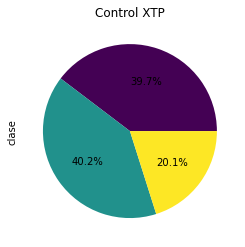

In [9]:
colors = cm.viridis(np.linspace(0,1,3))
#colores = [ 'slateblue', 'mediumseagreen', 'orange']
#plt.figure(figsize=(7,8))
#plt.figure(dpi=100)
XTP.clase[(XTP.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
#plt.xticks(fontsize=20)
#plt.xticks(fontsize=32)
plt.title('Control XTP')
XTP.longitud[(XTP.longitud>1)].count()

139

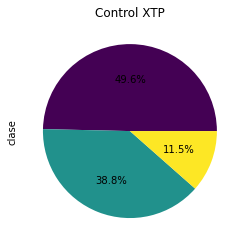

In [10]:
XTP.clase[(XTP.longitud >  1) & (XTP.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
plt.title('Control XTP');
XTP.longitud[(XTP.longitud >  1) & (XTP.longitud <  4)].count()


<AxesSubplot:ylabel='clase'>

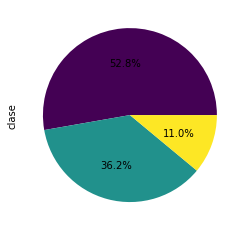

In [11]:
XTP.clase[(XTP.longitud >  1) & (XTP.longitud <  3.5)].value_counts(normalize=True).reindex(['rod', 'smile', 'snake']).plot.pie(colors = colors, labels=None, autopct = '%1.1f%%')

40

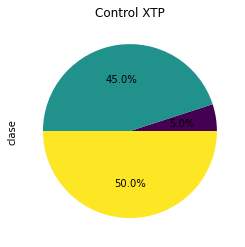

In [12]:
XTP.clase[(XTP.longitud >  4)].value_counts(normalize=True).reindex(['rod', 'smile', 'snake']).plot.pie(colors = colors, labels=None, autopct = '%1.1f%%')
plt.title('Control XTP')
XTP.longitud[(XTP.longitud>4)].count()

In [13]:
XTP.clase[(XTP.longitud >  4)].value_counts(normalize=True).reindex(['rod', 'sonrisa', 'viborita'])

rod         0.05
sonrisa      NaN
viborita     NaN
Name: clase, dtype: float64

## Resultados Latrunculina

In [14]:
index_lat = [os.path.basename(archivo) for archivo in lista_snakeLAT]
fechas_lat = [os.path.split(os.path.split(os.path.split(archivo)[0])[0])[1] for archivo in lista_snakeLAT]
lat_dict = {"fecha": fechas_lat, 'path': lista_snakeLAT}
LAT = pd.DataFrame(lat_dict, index= index_lat)

LAT['longitud'] = LAT['path'].apply(longitud)
LAT['clase'] = LAT['path'].apply(clase_factores)

185

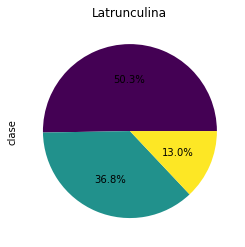

In [15]:
LAT.clase[(LAT.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');

plt.title('Latrunculina');

LAT.clase[(LAT.longitud >  1)].count()

127

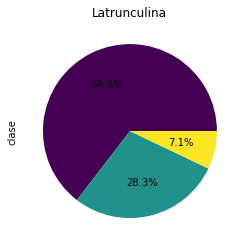

In [16]:
LAT.clase[(LAT.longitud >  1) & (LAT.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');

plt.title('Latrunculina');

LAT.clase[(LAT.longitud >  1) & (LAT.longitud <  4)].count()

58

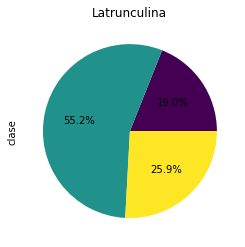

In [17]:
LAT.clase[(LAT.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');

plt.title('Latrunculina');

LAT.clase[(LAT.longitud >  4)].count()

## Resultados con vinblastina 10nM

In [18]:
index_vin = [os.path.basename(archivo) for archivo in lista_snakeVINB]
fechas_vin = [os.path.split(os.path.split(os.path.split(archivo)[0])[0])[1] for archivo in lista_snakeVINB]
vin_dict = {"fecha": fechas_vin, 'path': lista_snakeVINB}
VIN = pd.DataFrame(vin_dict, index= index_vin)

VIN['longitud'] = VIN['path'].apply(longitud)
VIN['clase'] = VIN['path'].apply(clase_factores)

151

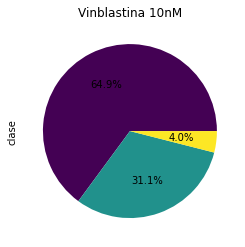

In [19]:
colors = cm.viridis(np.linspace(0,1,3))
#colores = [ 'slateblue', 'mediumseagreen', 'orange']
#plt.figure(figsize=(7,8))
VIN.clase[(VIN.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
#plt.xticks(fontsize=20)
plt.title('Vinblastina 10nM')
VIN.longitud[(VIN.longitud >  1)].count()

144

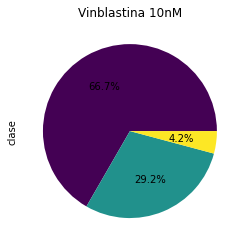

In [20]:
VIN.clase[(VIN.longitud >  1) & (VIN.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
plt.title('Vinblastina 10nM');
VIN.longitud[(VIN.longitud >  1) & (VIN.longitud <  4)].count()


6

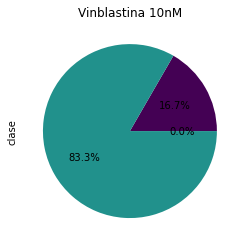

In [21]:
VIN.clase[(VIN.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
plt.title('Vinblastina 10nM')
VIN.longitud[(VIN.longitud >  4)].count()

In [22]:
VIN.clase[(VIN.longitud >  1) & (VIN.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake'])

rod      96
smile    42
snake     6
Name: clase, dtype: int64

In [23]:
VIN.clase[(VIN.longitud <  1)].value_counts().reindex(['rod', 'smile', 'snake'])

rod      40.0
smile     1.0
snake     NaN
Name: clase, dtype: float64

## Resultados Vimentina mutada roja

In [24]:
index_vim = [os.path.basename(archivo) for archivo in lista_snakeVIM]
fechas_vim = [os.path.split(os.path.split(os.path.split(archivo)[0])[0])[1] for archivo in lista_snakeVIM]
vim_dict = {"fecha": fechas_vim, 'path': lista_snakeVIM}
VIM = pd.DataFrame(vim_dict, index= index_vim)

VIM['longitud'] = VIM['path'].apply(longitud)
VIM['clase'] = VIM['path'].apply(clase_factores)

242

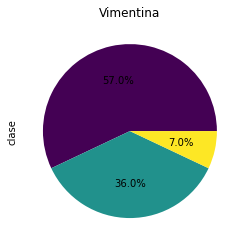

In [25]:
VIM.clase[(VIM.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');

plt.title('Vimentina');

VIM.longitud[(VIM.longitud >  1)].count()

199

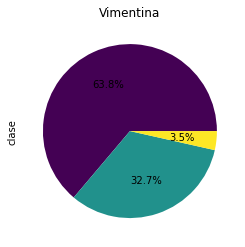

In [26]:
VIM.clase[(VIM.longitud >  1) & (VIM.longitud < 4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');

plt.title('Vimentina');

VIM.longitud[(VIM.longitud >  1) & (VIM.longitud < 4) ].count()

43

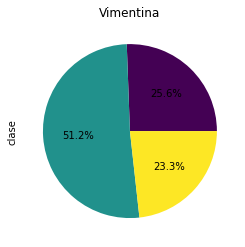

In [27]:
VIM.clase[(VIM.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');

plt.title('Vimentina');

VIM.longitud[(VIM.longitud >  4)].count()

## Resultados Nocodazol 16nM incubado 30'

In [28]:
index_noc = [os.path.basename(archivo) for archivo in lista_snakeNOC]
fechas_noc = [os.path.split(os.path.split(os.path.split(archivo)[0])[0])[1] for archivo in lista_snakeNOC]
noc_dict = {"fecha": fechas_noc, 'path': lista_snakeNOC}
NOC = pd.DataFrame(noc_dict, index= index_noc)

NOC['longitud'] = NOC['path'].apply(longitud)
NOC['clase'] = NOC['path'].apply(clase_factores)

144

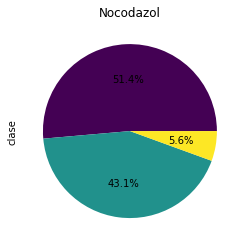

In [29]:
NOC.clase[(NOC.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');

plt.title('Nocodazol');

NOC.longitud[(NOC.longitud >  1)].count()

# Grafico en subplots todas las condiciones juntas

In [31]:
colors = cm.viridis(np.linspace(0,1,3))
fig = plt.figure(dpi=1600, figsize=(12,24))
ax = fig.add_subplot(151)
XTP.clase.value_counts().reindex(['rod', 'smile', 'snake']).plot.pie( colors= colors, labels=None, autopct = '%1.1f%%');
#plt.title('Control')
ax.set_ylabel('')
ax.set_xlabel('CTRL', fontsize=16);
#ax.set_xlabel('N = ' + str(XTP.longitud[(XTP.longitud >  1)].count()))

ax = fig.add_subplot(152)
NOC.clase.value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
#plt.title('Nocodazole');
ax.set_ylabel('')
ax.set_xlabel('NOC', fontsize=16);
#ax.set_xlabel('N = ' + str(NOC.longitud[(NOC.longitud >  1)].count()))

ax = fig.add_subplot(153)
LAT.clase.value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
#plt.title('Latrunculin');
ax.set_ylabel('')
ax.set_xlabel('LAT', fontsize=16);
#ax.set_xlabel('N = ' + str(LAT.longitud[(LAT.longitud >  1)].count()))

ax = fig.add_subplot(154)
VIM.clase.value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
#plt.title('Vimentin(1-138)');
ax.set_ylabel('')
ax.set_xlabel('VIM$^{-}$', fontsize=16);
#ax.set_xlabel('N = ' + str(VIM.longitud[(VIM.longitud >  1)].count()))

ax = fig.add_subplot(155)
VIN.clase.value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None, autopct = '%1.1f%%');
#plt.title('Vinblastin')
ax.set_ylabel('')
ax.set_xlabel('VINB', fontsize=16);
#ax.set_xlabel('N = ' + str(VIN.longitud[(VIN.longitud >  1)].count()))



## L>1

In [30]:
colors = cm.viridis(np.linspace(0,1,3))
fig = plt.figure(dpi=1600, figsize=(12,24))
ax = fig.add_subplot(151)
XTP.clase[(XTP.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie( colors= colors, labels=None)#, autopct = '%1.1f%%');
#plt.title('Control')
ax.set_ylabel('')
ax.set_xlabel('CTRL', fontsize=16);
#ax.set_xlabel('N = ' + str(XTP.longitud[(XTP.longitud >  1)].count()))

ax = fig.add_subplot(153)
LAT.clase[(LAT.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
#plt.title('Latrunculin');
ax.set_ylabel('')
ax.set_xlabel('LAT', fontsize=16);
#ax.set_xlabel('N = ' + str(LAT.longitud[(LAT.longitud >  1)].count()))

ax = fig.add_subplot(154)
VIM.clase[(VIM.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
#plt.title('Vimentin(1-138)');
ax.set_ylabel('')
ax.set_xlabel('VIM$^{-}$', fontsize=16);
#ax.set_xlabel('N = ' + str(VIM.longitud[(VIM.longitud >  1)].count()))

ax = fig.add_subplot(152)
NOC.clase[(NOC.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
#plt.title('Nocodazole');
ax.set_ylabel('')
ax.set_xlabel('NOC', fontsize=16);
#ax.set_xlabel('N = ' + str(NOC.longitud[(NOC.longitud >  1)].count()))

ax = fig.add_subplot(155)
VIN.clase[(VIN.longitud >  1)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
#plt.title('Vinblastin')
ax.set_ylabel('')
ax.set_xlabel('VINB', fontsize=16);
#ax.set_xlabel('N = ' + str(VIN.longitud[(VIN.longitud >  1)].count()))



## 1<L<4

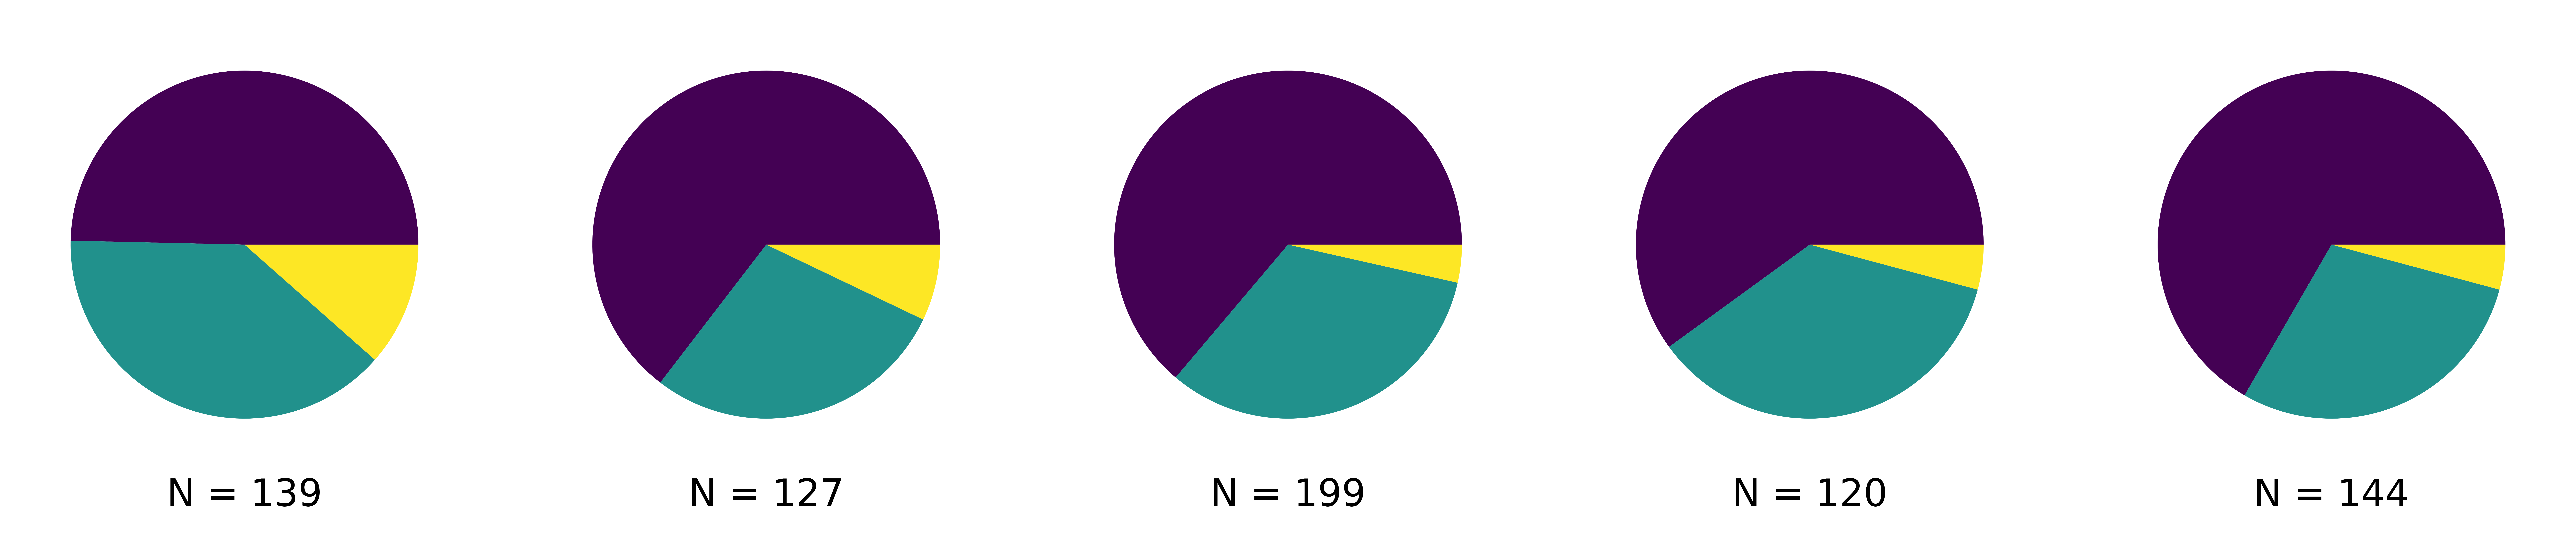

In [32]:
fig = plt.figure(dpi=1600, figsize=(12,24))

ax = fig.add_subplot(151)
XTP.clase[(XTP.longitud >  1)&(XTP.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie( colors= colors, labels=None);# autopct = '%1.1f%%');
#plt.title('Control')
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(XTP.longitud[(XTP.longitud >  1)&(XTP.longitud <  4)].count()));

ax = fig.add_subplot(152)
LAT.clase[(LAT.longitud >  1)&(LAT.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None);#, autopct = '%1.1f%%');
#plt.title('Latrunculina');
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(LAT.longitud[(LAT.longitud >  1)&(LAT.longitud <  4)].count()));

ax = fig.add_subplot(153)
VIM.clase[(VIM.longitud >  1)&(VIM.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None);#, autopct = '%1.1f%%');
#plt.title('Vimentina');
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(VIM.longitud[(VIM.longitud >  1)&(VIM.longitud <  4)].count()));

ax = fig.add_subplot(154)
NOC.clase[(NOC.longitud >  1)&(NOC.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None);#, autopct = '%1.1f%%');
#plt.title('Nocodazol');
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(NOC.longitud[(NOC.longitud >  1)&(NOC.longitud <  4)].count()));

ax = fig.add_subplot(155)
VIN.clase[(VIN.longitud >  1)&(VIN.longitud <  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None);#, autopct = '%1.1f%%');
#plt.title('Vinblastina')
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(VIN.longitud[(VIN.longitud >  1)&(VIN.longitud <  4)].count()));



## L > 4

In [33]:
fig = plt.figure(dpi=1600, figsize=(12,24))
ax = fig.add_subplot(151)
XTP.clase[(XTP.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie( colors= colors, labels=None)#, autopct = '%1.1f%%');
plt.title('Control')
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(XTP.longitud[(XTP.longitud >  4)].count()));

ax = fig.add_subplot(152)
LAT.clase[(LAT.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
plt.title('Latrunculina');
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(LAT.longitud[(LAT.longitud >  4)].count()));

ax = fig.add_subplot(153)
VIM.clase[(VIM.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
plt.title('Vimentina');
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(VIM.longitud[(VIM.longitud >  4)].count()));

ax = fig.add_subplot(154)
NOC.clase[(NOC.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
plt.title('Nocodazol');
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(NOC.longitud[(NOC.longitud >  4)].count()));

ax = fig.add_subplot(155)
VIN.clase[(VIN.longitud >  4)].value_counts().reindex(['rod', 'smile', 'snake']).plot.pie(colors= colors, labels=None)#, autopct = '%1.1f%%');
plt.title('Vinblastina')
ax.set_ylabel('')
ax.set_xlabel('N = ' + str(VIN.longitud[(VIN.longitud >  4)].count()));


## Otras funciones para graficar cosas

In [32]:
def grafico_recta(archivo):
    datos_xy = coordenadas_frame(archivo)
    #datos_xy = datos[:,2:]


    recta, parametros = es_recta(datos_xy)

    x_modelo  = np.linspace(np.min(datos_xy[:,0]), np.max(datos_xy[:,0]), 200)

    plt.figure(figsize=(6,4) )#tamaño_figura)
    #plt.plot(datos_xy[:,0], datos_xy[:,1],'o', color = 'tab:red',  markersize= tamaño_circulo)
    plt.plot(datos_xy[:,0], datos_xy[:,1],'o', color = 'red',  markersize= 20)
    #plt.plot(x_modelo, mod_recta(x_modelo, *parametros), '--', color='black', linewidth= ancho_linea)
    plt.xlabel('X', fontsize= tamaño_labels)
    #plt.ylabel('Y', fontsize= tamaño_labels)
    bottom, top = plt.ylim()  # return the current ylim
    plt.ylim(( top, bottom)) 
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])

In [4]:
def grafico_reconstruccion(archivo, nmod=5):
    
    datos = coordenadas_frame(archivo)
    
    delta_s, theta = cambio_coord(datos)

    an = modos_fourier(theta, delta_s= delta_s, nmodos= nmod)

    theta2_fourier = tita_fourier(an,long_arco(delta_s), Lc= sum(delta_s))

    #ax2 = plt.figure( figsize=(10,4))
    #fig.suptitle(lista_snake[ind][52:60]+' img ' + lista_snake[ind][83:-4], fontsize=16)
    plt.figure(figsize= tamaño_figura)
    plt.plot(long_arco(delta_s),theta - np.mean(theta), 'o', markersize = tamaño_circulo+2, color='steelblue')
    plt.plot(long_arco(delta_s), theta2_fourier - np.mean(theta2_fourier), linewidth = ancho_linea+2, color='darkorange' )
    #ax2.legend()
    
    plt.ylabel('tangent angle $\\theta$(s)', fontsize= tamaño_labels)

    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    
#grafico_reconstruccion(mito_smile)

In [5]:
def grafico_fourier(archivo, nmod=5):
    
    datos = coordenadas_frame(archivo)
    delta_s, theta = cambio_coord(datos)

    an = modos_fourier(theta, delta_s= delta_s, nmodos= nmod)

    plt.figure( figsize= tamaño_figura)
    #fig.suptitle(lista_snake[ind][52:60]+' img ' + lista_snake[ind][83:-4], fontsize=16)

    plt.axhline(y = 0, color = 'silver', linestyle = '--', linewidth = ancho_linea-3)
    plt.plot(np.arange(nmod)+1,np.abs(an),'o--', color = 'darkorange', markersize = tamaño_circulo+10, linewidth = ancho_linea-2)
    
    plt.xlabel('mode number, n', fontsize=tamaño_labels)
    plt.ylabel('mode amplitude $a_n$', fontsize= tamaño_labels)
    plt.xticks([1,2,3,4,5], fontsize=tamaño_ticks)
    #plt.yticks([0], fontsize=tamaño_ticks)
    plt.yticks([],[])
    plt.axis('off')
    plt.tight_layout()
    #fig.subplots_adjust(top=0.83)
    
#grafico_fourier(mito_snake)

# Figura 5: trayectorias de mitocondrias

Figura principal mostrando las trayectorias de las mitocondrias dependiendo la duración de la película, si la trayectoria es procesiva o encapsulada no depende de la duración. Figuras auxiliares mostrando trayectorias característicamente procesivas por un lado y encapsuladas por el otro, con código de colores de la forma. Ver que las procesivas coinciden con mayor proporción de rods.

Códigos de imagen provistos por Luciana en Matlab

In [3]:
import scipy.io
mat = scipy.io.loadmat('datos_figuras/Data_trayectorias_CM.mat')
data = mat['data'] #data es una matriz que tiene columnas tiempo,longitud, xcm , ycm para cada mitocondria

cc= cc1 = cc2 = cc3 = cc4 = cc5 =1;

color_trayectorias = cm.magma(np.linspace(0,1,5))
plt.figure(figsize= tamaño_figura)

for k in np.arange(start=2, stop=163, step=4):

    xcm=data[data[:,k]>0,k]-data[0,k];

    ycm=data[data[:,k]>0,k+1]-data[0,k+1];

    tcm=data[data[:,k]>0,k-2];

    
    if (np.max(tcm)>24) & (np.max(tcm)<50):

        xcm=xcm+cc1;

        cc1=cc1+1.2;

        plt.plot(xcm[tcm<25],ycm[tcm<25], color = color_trayectorias[0], linewidth = 5)

    cc=cc+1;
    
    if (max(tcm)>50) & (max(tcm)<100):

        xcm=xcm+cc2;

        cc2=cc2+1.2;

        ycm=ycm + 1;

        plt.plot(xcm[tcm<51], ycm[tcm<51], color = color_trayectorias[1], linewidth=5)

    cc=cc+1;

    if (np.max(tcm)>150) & (np.max(tcm)<200):

        xcm=xcm+cc3;

        cc3=cc3+1.2;

        ycm=ycm + 2.5;

        plt.plot(xcm[tcm<151],ycm[tcm<151], color = color_trayectorias[2], linewidth = 5)

    cc=cc+1;


    if (np.max(tcm)>249) & (np.max(tcm)<298):

        xcm=xcm+cc4;

        cc4=cc4+1.2;

        ycm=ycm+4;

        plt.plot(xcm[tcm<250], ycm[tcm<250], color = color_trayectorias[3], linewidth=5)

    cc=cc+1;

plt.axis('off');

NameError: name 'tamaño_figura' is not defined

In [4]:
def variables(data, k):
    xcm_nan= data[~np.isnan(data[:,k]),k] # saco los nan

    xcm = xcm_nan[xcm_nan>0] - xcm_nan[0] #me quedo con las posiciones que no son cero

    ycm_nan= data[~np.isnan(data[:,k+1]),k+1]

    ycm = ycm_nan[ycm_nan>0] - ycm_nan[0]

    tcm_nan= data[~np.isnan(data[:,k-2]),k-2];

    tcm = tcm_nan[tcm_nan>0]

    f= data[~np.isnan(data[:,k+2]),k+2]; #formas

    long = data[~np.isnan(data[:,k-1]),k-1]

    Le= np.mean(long[long>0]);
    
    return(xcm, ycm, tcm, f, Le)

def grafico_trayectoria(xcm, ycm, f, ccx):
    xcm=xcm+ccx;
    plt.plot(xcm, ycm, color='gray', zorder=1)
    plt.scatter(xcm, ycm, s=50, c=f, cmap='viridis', vmin=1, vmax=3, zorder=2)
    
mat = scipy.io.loadmat('datos_figuras/Data_trayectorias_CM_formas.mat')
data = mat['data'] #data es una matriz que tiene columnas tiempo,longitud, xcm , ycm para cada mitocondria

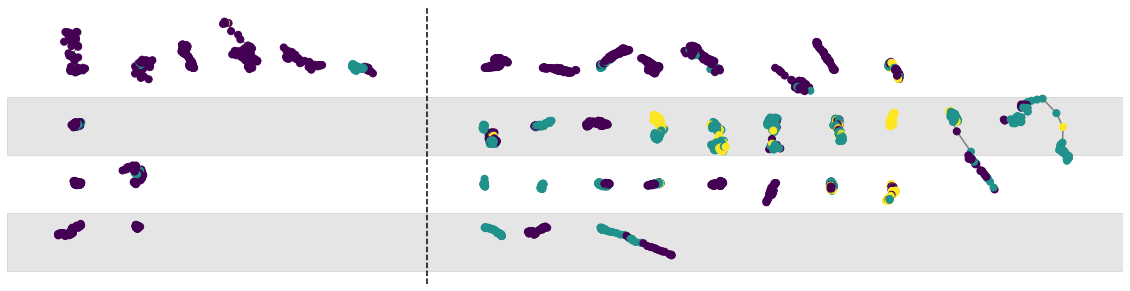

In [24]:
cc=1;
cc1=cc2=cc3=cc4=cc5=1;

plt.figure(figsize= (20,8))

for n in range(41):    
    k = 2 + 5*n
    xcm, ycm, tcm, f, Le = variables(data, k)
    if (Le<1.5) & (k != (2 + 5*1)): # O la mediana o <1, 1<4, >4

        if  max(tcm)<50:
            grafico_trayectoria(xcm, ycm, f, cc1)
            cc1=cc1+2; 
            cc=cc+1;

        if (max(tcm)>50) & (max(tcm)<100):
            grafico_trayectoria(xcm, ycm + 1.5, f, cc2)
            cc2=cc2+2;
            cc=cc+1;

        if (max(tcm)>100) & (max(tcm)<200):
            grafico_trayectoria(xcm, ycm + 3.5, f, cc3)
            cc3=cc3+2;
            cc=cc+1;

        if max(tcm)>200: # %&& max(tcm)<298
            grafico_trayectoria(xcm, ycm+ 5.5, f, cc4)
            cc4=cc4+2;
            ycm=ycm+5.5;
            cc=cc+1;

ccmax = max(cc1,cc2,cc3,cc4)
cc1 = cc2 = cc3 = cc4 = ccmax + 2

for n in range(41):    
    k = 2 + 5*n
    xcm, ycm, tcm, f, Le = variables(data, k)
    if (Le>1.5) & (k != (2 + 5*35)) & (k != (2 + 5*40)): # O la mediana o <1, 1<4, >4

        if  max(tcm)<50:
            grafico_trayectoria(xcm, ycm, f, cc1)
            cc1=cc1+2; 
            cc=cc+1;

        if (max(tcm)>50) & (max(tcm)<100):
            grafico_trayectoria(xcm, ycm + 1.5, f, cc2)
            cc2=cc2+2;
            cc=cc+1;

        if (max(tcm)>100) & (max(tcm)<200):
            grafico_trayectoria(xcm, ycm + 3.5, f, cc3)
            cc3=cc3+2;
            cc=cc+1;

        if max(tcm)>200: # %&& max(tcm)<298
            grafico_trayectoria(xcm, ycm+ 5.5, f, cc4)
            cc4=cc4+2;
            ycm=ycm+5.5;
            cc=cc+1;

#grafico las que saque que son largas y se van para arriba/abajo
xcm, ycm, tcm, f, Le = variables(data, k=2 + 5*40 )          
grafico_trayectoria(xcm, ycm + 4, f, cc3)

xcm, ycm, tcm, f, Le = variables(data, k=2 + 5*35 )          
grafico_trayectoria(xcm, ycm + 2.5, f, cc3+4)

plt.axvline(x=ccmax , color='black', ls='--')
yticks, _ = plt.yticks()
plt.axhspan(-1.5, 0.5, color='black', alpha=0.1, zorder=0)
plt.axhspan(2.5, 4.5, color='black', alpha=0.1, zorder=0)
plt.axis('off');
plt.gca().set_aspect('equal', adjustable='box')

([], <a list of 0 Text yticklabel objects>)

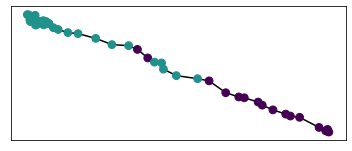

In [5]:
k=2+5*10

xcm, ycm, tcm, f, Le = variables(data, k)

plt.scatter(xcm, ycm, s=60, c=f, cmap='viridis', vmin=1, vmax=3, zorder=2)
plt.plot(xcm, ycm, color='black', zorder=1)
#plt.ylim([-2.8,0.2]) #40
#plt.xlim([-0.5, 2.5]) #40
#plt.ylim([-1.5,1.5]) #38
#plt.xlim([-0.2, 0.6]) #38
#plt.xlim([-1.5, 1.5]) #31
#plt.ylim([-1, 2]) #31
#plt.xlim([-0.2, 2.8]) #10

#plt.xlim([-1.5, 1.5])
#plt.ylim([-2, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([])
plt.yticks([])

In [6]:
xcm

array([ 0.        ,  0.01416183, -0.01356394,  0.00886844,  0.04999926,
        0.01743412,  0.03624272,  0.01251604,  0.01152214,  0.03892128,
        0.0069545 ,  0.05305654,  0.06854501,  0.08880284,  0.06737868,
        0.11932693,  0.11213671,  0.11631254,  0.1391868 ,  0.15880895,
        0.16271559,  0.19794114,  0.23653401,  0.31595499,  0.39862949,
        0.54246459,  0.67382703,  0.80956835,  0.88119443,  0.96523704,
        1.01938828,  1.07728092,  1.09290251,  1.19743121,  1.37012348,
        1.46382368,  1.59915393,  1.70530117,  1.75001167,  1.86245991,
        1.89591073,  1.98270495,  2.08705705,  2.12465473,  2.19954391,
        2.35749743,  2.41168382,  2.43742409,  2.42398007,  2.42716321])

In [7]:
ycm

array([ 0.        , -0.01209529,  0.00284925, -0.01181075, -0.00263038,
       -0.03979472, -0.02614346, -0.0175332 , -0.05332239, -0.0282993 ,
       -0.04285271, -0.08199925, -0.0751643 , -0.05517475, -0.04766667,
       -0.08037653, -0.05571467, -0.04619737, -0.05369127, -0.06947708,
       -0.07007824, -0.10322508, -0.11799089, -0.1431273 , -0.15168548,
       -0.1902549 , -0.24108052, -0.24939616, -0.27982422, -0.34919563,
       -0.38339457, -0.38970807, -0.44048619, -0.49304809, -0.51798218,
       -0.53565949, -0.63197011, -0.66643335, -0.67313058, -0.70791496,
       -0.7333004 , -0.77142313, -0.80578731, -0.82162461, -0.83195318,
       -0.91406814, -0.94126554, -0.95149661, -0.94587207, -0.93047142])

In [27]:
Le

3.2302999999999997

procesivas (k = 2 + 5*n)

n = 10 --> smile y rod , 2.5 um en x y 1um en y (seguro)  [img 09 mito 1]

n=31 --> rod , lineal, 0.6 en x y 0.8 en y (seguro)  [img 25 mito 5]

encarceladas
n = 7 --> 0.4 en x y 0.16 en y todas las formas (no las use al final)
n = 13 , 0.16 en x y 0.35 en y , todas las formas (no las use al final)

n=38 --> todas formas, 0.8 en y y 0.2 en x [img 34 mito 3]


n=29 ovillo 
n=37 [img 34 mito 2]

# Fig 6: persistencia de formas

La idea acá es mostrar la autocorrelación de los tiempos en que están las formas.

Vamos a usar la película 34, mito 3(?, que presenta las 3 formas de forma representativa. Vamos a colocar un panel con la formas en el tiempo y uno con la autocorrelación de formas y su ajuste exponencial. Además agregamos 3 frames donde se reconozcan las 3 formas:

rod-like --> frame

smile --> frame

snake --> frame

In [28]:
#persistencia_1 = np.loadtxt('datos_figuras/Figura_persistencia_forma_1.txt')
#persistencia_2 = np.loadtxt('datos_figuras/Figura_persistencia_forma_2.txt')
#autocorrelacion_1 = np.loadtxt('datos_figuras/Figura_autocorrelacion_forma_1.txt')
#autocorrelacion_2 = np.loadtxt('datos_figuras/Figura_autocorrelacion_forma_2.txt')
def fig_persistencia(datos):
    plt.figure(figsize=(10,6))
    plt.plot(datos[:,0], datos[:,1], lw=8, color='cadetblue')
    plt.yticks([1,2,3],['rod','smile', 'snake'], fontsize=32)
    plt.xticks(fontsize=28)
    plt.xlabel('time (s)', fontsize=32)
    
def fig_autocorrelacion(datos):
    plt.figure(figsize=(8,6))
    plt.plot(datos[:,0], datos[:,1],'o', markersize=15,color='cadetblue')
 
    plt.yticks( fontsize=28)
    plt.xticks(fontsize=28)
    plt.xlabel('time lag (s)', fontsize=32)
    #plt.ylabel('f(t)*f(t+$\\tau$)', fontsize=32)
    plt.ylabel('ACF', fontsize=38)

(0.75, 3.75)

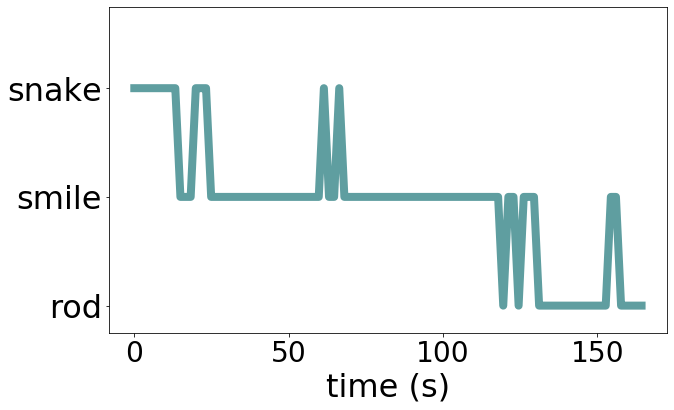

In [29]:
fig_persistencia(np.loadtxt('datos_figuras/Figura_forma_mito41.txt'))
plt.xticks([0,50,100,150]);
plt.ylim([0.75,3.75])

Text(0.5, 0, '')

<Figure size 504x864 with 0 Axes>

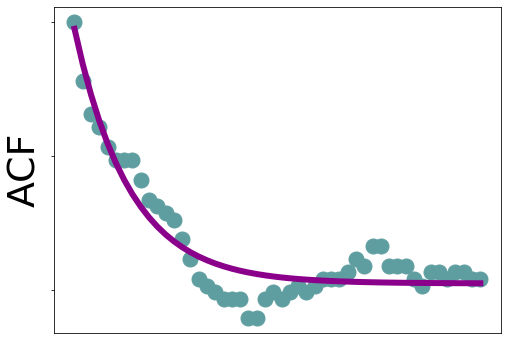

In [30]:
autocorrelacion = np.loadtxt('datos_figuras/Figura_autocorrelacion_forma_mito41.txt')
plt.figure(figsize=(7,12));
fig_autocorrelacion(autocorrelacion)
plt.plot(autocorrelacion[:,0],autocorrelacion[:,2], lw=6, color='darkmagenta')
plt.yticks([0.9,0.95,1],[]);
plt.xticks([],[]);
plt.xlabel('')

## Grafico de barras con tiempos de persistencia de formas

Timelife de las formas

Rod: 3.5 +/- 1.2  s

Smile: 5.5 +/- 1.2 s

Snake: 2 +/-1 s

shapes persistence time : $6.6 \pm 2.7 s $

Text(0, 0.5, 'time (s)')

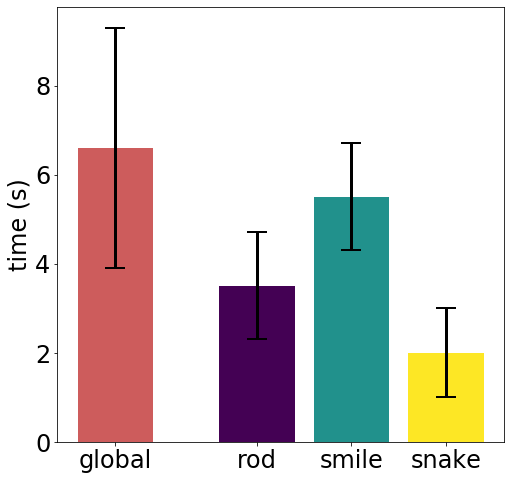

In [31]:
tiempos = [6.6, 3.5, 5.5, 2]
errores = [2.7, 1.2, 1.2, 1]

posiciones = [0, 1.5, 2.5, 3.5]

import matplotlib.colors as pltcolor
cadete = list(pltcolor.to_rgba('indianred'))
virid = cm.viridis(np.linspace(0,1,3))

colores_barra = [cadete, virid[0], virid[1], virid[2]]


plt.figure(figsize=(8,8))
#plt.bar(posiciones, tiempos, yerr=errores, color = ['cadetblue', 'purple', 'turquoise', 'yellow'])
plt.bar(posiciones, tiempos, color = colores_barra, linewidth=10)
plt.errorbar(posiciones,tiempos, yerr=errores, color='black', fmt='none', linewidth=3, capsize=10, capthick=2)
plt.xticks([0,1.5,2.5,3.5],['global', 'rod','smile','snake'], fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('time (s)', fontsize=24)

In [32]:
cm.viridis(np.linspace(0,1,3))[0]

array([0.267004, 0.004874, 0.329415, 1.      ])

In [33]:
import matplotlib.colors as pltcolor
cadete = pltcolor.to_rgba('cadetblue')

In [34]:
list(cadete)

[0.37254901960784315, 0.6196078431372549, 0.6274509803921569, 1.0]

In [35]:
colores_barra

[[0.803921568627451, 0.3607843137254902, 0.3607843137254902, 1.0],
 array([0.267004, 0.004874, 0.329415, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ])]

# Revisión: figuras nuevas

Primero forma de mitocondria para comprar con eventos de fuerzas activas.
